### 인물모드 사진의 대표적인 문제점
- 머리카락, 귀등 background와 인물간의 경계에 위치하는 부분들이 잘리거나 덮어지는 경우가 존재한다.
- 배경과 객체의 색 혹은 질감이 비슷하면 오분류가 일어나는 경우가 있다

### Semantic Segmentation Mask의 한계
- 특정 픽셀에 대해 해당 객체가 존재하는지 아닌지만 판단하기 때문에 경계의 연속성이나 투명도들을 자연스럽게 표현하기 어렵다.

#### 어떻게 극복할 수 있을까?
- Segmentation 이후 CRF, guided filter, smoothing 등의 refinement 기법을 적용하면, 경계 주변의 불연속적인 픽셀 분류를 완화하여 인물과 배경 사이의 경계를 보다 부드럽고 자연스럽게 표현할 수 있다.
- Depth + Segmentation 결합을 통해 단순히 객체를 분리하고 pixel마다의 찾는것이 아니라, 깊이 정보를 기반으로 blur를 조절하게 되면, 보다 정확하고 자연스러운 segmentation을 수행할 수 있을것 같다.

### 아웃포커싱 효과 구현
(인물모드 사진, 동물 사진)

In [1]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

In [2]:
def load_model(device="cpu"):
    model = deeplabv3_resnet101(pretrained=True).to(device)
    model.eval()
    return model

def load_image(img_path):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_bgr, img_rgb

def preprocess_image(img_bgr, size=(520, 520)):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(size),
        T.ToTensor(),
    ])
    input_tensor = transform(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    return input_tensor.unsqueeze(0)


In [3]:
def run_segmentation(model, input_tensor, orig_shape, device="cpu"):
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        pred = output.argmax(0).byte().cpu().numpy()

    # 원본 크기로 복원
    h, w = orig_shape[:2]
    pred_resized = cv2.resize(pred, (w, h), interpolation=cv2.INTER_NEAREST)
    return pred_resized


def get_object_mask(segmentation_map, class_id):
    # segmentation map에서 class_id에 해당하는 위치 선택 (True/False) (마스킹 처리)
    mask = (segmentation_map == class_id).astype(np.uint8) * 255
    return mask


def apply_background_blur(img_bgr, mask, blur_ksize=(50, 50)):
   # 전체 이미지에 블러 적용
    img_blur = cv2.blur(img_bgr, blur_ksize)

    # grayscale -> RGB 변환
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # 마스크 반전(배경영역)
    inv_mask = cv2.bitwise_not(mask_3ch)
    # blur 배경 추출
    bg = cv2.bitwise_and(img_blur, inv_mask)
    # 원본 전경 추출
    fg = cv2.bitwise_and(img_bgr, mask_3ch)

    # 전경 + blur된 배경 합성
    result = cv2.add(bg, fg)
    return result


# 실행 코드
def segment_object_and_blur_bg(
    img_path,
    model,
    class_id=15,          # configuration !
    device="cpu",
    blur_ksize=(50, 50)
):
    img_bgr, img_rgb = load_image(img_path)
    input_tensor = preprocess_image(img_bgr)
    
    seg_map = run_segmentation(
        model,
        input_tensor,
        img_bgr.shape,
        device
    )

    object_mask = get_object_mask(seg_map, class_id)
    result = apply_background_blur(img_bgr, object_mask, blur_ksize)

    return {
        "original": img_rgb,
        "segmentation": seg_map,
        "mask": object_mask,
        "result": result
    }


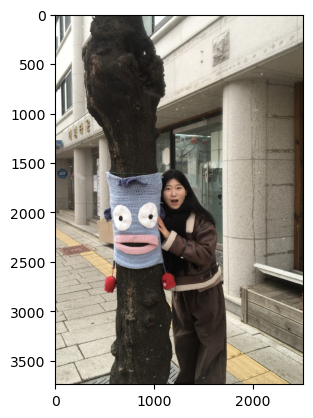

In [21]:
# 원본 사진
device = "cuda" if torch.cuda.is_available() else "cpu"
home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/AIFFEL_quest_rs/Exploration/EX02/image/taekyung.jpg")
plt.imshow(load_image(img_path)[-1])


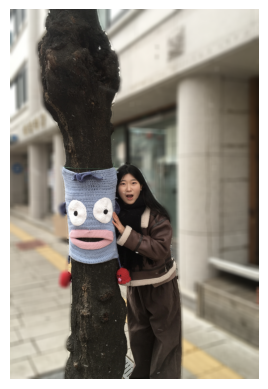

In [22]:
# 사람 아웃포커싱 효과를 수행한 결과 사진
model = load_model(device)

outputs = segment_object_and_blur_bg(
    img_path=img_path,
    model=model,
    class_id = 15,
    device=device
)

plt.imshow(cv2.cvtColor(outputs["result"], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

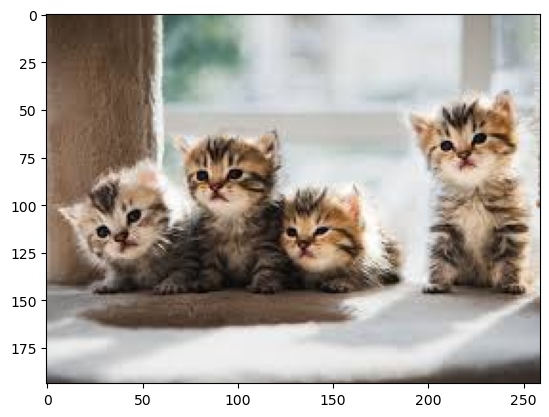

In [25]:
# Cat 원본 사진
home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/AIFFEL_quest_rs/Exploration/EX02/image/cat.jpg")
plt.imshow(load_image(img_path)[-1])

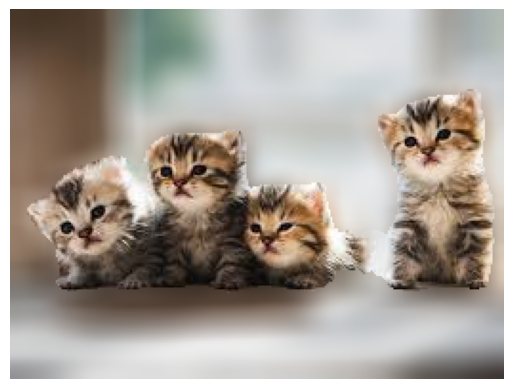

In [27]:
# cat 아웃포커싱 효과 준 결과 사진

model = load_model(device)

outputs = segment_object_and_blur_bg(
    img_path=img_path,
    model=model,
    device=device,
    class_id = 8,
    blur_ksize = (20,20) # 커널 비율도 조정했습니다

)

plt.imshow(cv2.cvtColor(outputs["result"], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### 구현한 인물사진 모드에서 발생한 문제점
- 해당 인물사진 모드에서는 semantic segmentation 기반으로 인물 클래스를 설정해야 하므로, 새로운 객체에 대해 매번 클래스를 추가적으로 정의해야 하는 확장성의 한계가 존재한다.
- 첫번째 내 사진(인물사진)의 결과물을 확인해보면, 사람뿐만 아니라 인물과 인접해 있던 나무까지 하나의 클래스로 함께 인식되는 문제가 발생하였다. 이는 semantic segmentation이 객체 단위가 아닌 픽셀 단위의 클래스 분류만을 수행하기 때문에, 서로 겹쳐 있거나 밀접한 객체를 명확한 개별 인스턴스로 분리하지 못하는 데서 문제가 발생한것 같다.  이러한 문제를 해결하기 위해 instance segmentation 기반 모델을 적용한다면, 동일한 클래스 내에서도 개별 객체를 구분할 수 있어 인물과 배경 객체를 보다 정확하게 분리할 수 있을 것 같다.
- 고양이 사진도 확인해보면 고양이 귀가 자연스럽지 않게 짤리는 느낌으로 blur 처리가 된 것을 확인할 수 있습니다.

### 배경전환 크로마키 사진 만들기 
(사막 배경에 고양이 사진 합치기)

In [6]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (194, 259, 3)
배경(사막) 이미지 크기: (183, 275, 3)


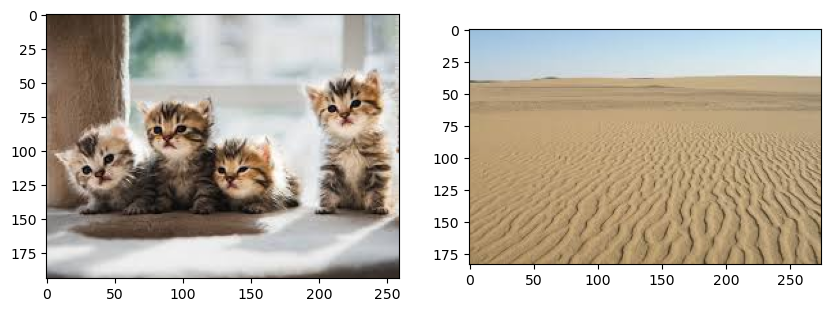

In [7]:
cat_img_path = "image/cat.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "image/sand.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [8]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [9]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (194, 259)


In [10]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


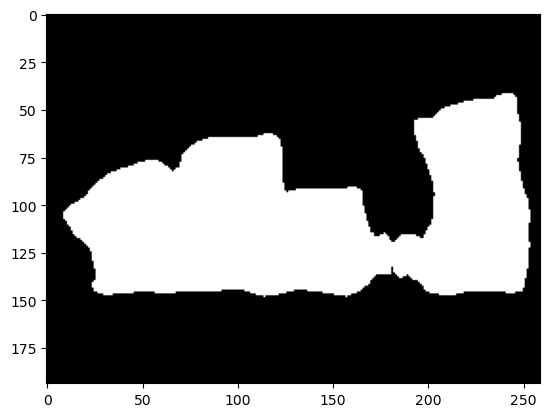

In [11]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

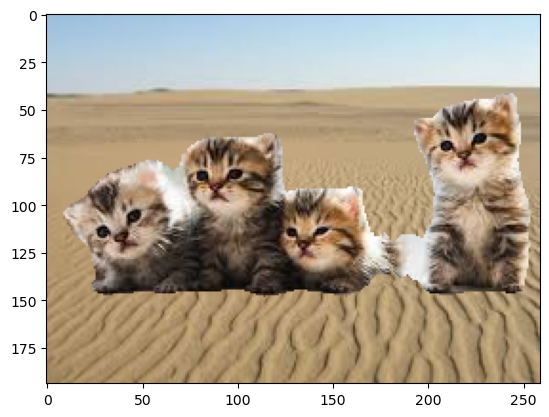

In [12]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()